In [157]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [158]:
import warnings
warnings.filterwarnings('ignore')

In [159]:
import pandas as pd
import numpy as np

In [160]:
all_data = pd.read_csv('subtraction_before_dummy.csv')

In [161]:
all_data.head()

,Strain,Orien,Aspect,Size,Subtraction
0,1,4,4,5,117.53
1,2,4,2,3,13.29
2,3,1,1,5,202.06
3,2,4,1,5,52.88
4,2,2,2,4,18.55


In [162]:
all_data.shape

(168, 5)

In [163]:
y_train = all_data.Subtraction.values
train = all_data.drop('Subtraction', axis=1).values

In [164]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    train, y_train, test_size=0.1, random_state=42
)

## cross-validation開始

In [165]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [166]:
n_folds = 10

def rmsle_cv(model):
    kf = StratifiedKFold(n_folds, shuffle=True, random_state=42).get_n_splits(xtrain)
    rmse= np.sqrt(-cross_val_score(model, xtrain, ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 様々な予測器を試す。

In [167]:
from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [168]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [169]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [170]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)

In [171]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

## それぞれの予測器のrmseをみる

In [172]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 17.6210 (9.0068)



In [173]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 17.1208 (9.1635)



In [174]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 17.1744 (9.0170)



In [175]:
score = rmsle_cv(lin_reg)
print("\nlin_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


lin_reg score: 20.0726 (10.1717)



In [176]:
score = rmsle_cv(forest_reg)
print("\nforest_reg score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


forest_reg score: 17.7408 (7.3599)



## random forestのGridSearch開始

In [177]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [60, 70, 80 ], 'max_features': [0.0000001, 0.000001]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [0.01, 0.1]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [60, 70, 80], 'max_features': [1e-07, 1e-06]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [178]:
rmse_test_score = np.sqrt(-grid_search.score(xtest, ytest))
rmse_cross_score = np.sqrt(-grid_search.best_score_)

print('Test set score: {}'.format(rmse_test_score))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(rmse_cross_score))

Test set score: 44.84493736468038
Best parameters: {'max_features': 1e-07, 'n_estimators': 60}
Best cross-validation: 18.507648068644247


In [179]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

18.507648068644247 {'max_features': 1e-07, 'n_estimators': 60}
18.70824644862078 {'max_features': 1e-07, 'n_estimators': 70}
18.940124663158517 {'max_features': 1e-07, 'n_estimators': 80}
18.507648068644247 {'max_features': 1e-06, 'n_estimators': 60}
18.70824644862078 {'max_features': 1e-06, 'n_estimators': 70}
18.940124663158517 {'max_features': 1e-06, 'n_estimators': 80}
21.410632883945016 {'bootstrap': False, 'max_features': 0.01, 'n_estimators': 3}
20.225881106514496 {'bootstrap': False, 'max_features': 0.01, 'n_estimators': 10}
21.410632883945016 {'bootstrap': False, 'max_features': 0.1, 'n_estimators': 3}
20.225881106514496 {'bootstrap': False, 'max_features': 0.1, 'n_estimators': 10}


In [180]:
def cc(y, y_pre):
    correlation = pd.DataFrame({'y':y, 'y_pre':y_pre})
    return print('correlation coefficient is: {0:0.3f}'.format(correlation.corr().iloc[0,1]))

forest_reg = RandomForestRegressor(max_features=0.1, n_estimators=75, random_state=1)
forest_reg.fit(xtrain, ytrain)
cc(forest_reg.predict(xtest), ytest)

correlation coefficient is: 0.649


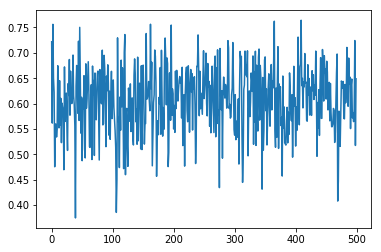

In [181]:
import matplotlib.pyplot as plt

nrange = range(0,500)
grid_score = []
feature_importances = np.ones((0,4))

for i in nrange:
    forest_reg = RandomForestRegressor(random_state=i)
    forest_reg.fit(xtrain, ytrain)
    correlation = pd.DataFrame({'y':ytest, 'y_pre':forest_reg.predict(xtest)})
    grid_score.append(correlation.corr().iloc[0,1])
    fi = forest_reg.feature_importances_.reshape(1,-1)
    feature_importances = np.r_[feature_importances, fi]
plt.plot(nrange, grid_score)

In [182]:
feature_importances.mean(axis=0)

array([0.10761644, 0.1561604 , 0.1135627 , 0.62266045])

### random forestのfeature_importances_

In [183]:
feature_importances = forest_reg.feature_importances_
feature_importances

array([0.08172927, 0.15498243, 0.12245007, 0.64083824])

In [184]:
all_data.columns

Index(['Strain', 'Orien', 'Aspect', 'Size', 'Subtraction'], dtype='object')

## correlation coefficientを計算する

In [185]:
def cc(y, y_pre):
    correlation = pd.DataFrame({'y':y, 'y_pre':y_pre})
    return print('correlation coefficient is: {0:0.3f}'.format(correlation.corr().iloc[0,1]))

In [186]:
a = grid_search.predict(xtest)

In [187]:
cc(a, ytest)

correlation coefficient is: 0.625


## 予測器をlightgbmにし、GridSearchを行う。

In [188]:
from sklearn.model_selection import KFold, train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    train, y_train, test_size=0.1, random_state=42
)

In [189]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression')

In [190]:
model_lgb.fit(xtrain, ytrain)
print('チューニング前')
cc(model_lgb.predict(xtest), ytest)

チューニング前
correlation coefficient is: 0.718


## チューニングする

## ベストなハイパーパラメータ入力

In [191]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=2,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 5, bagging_fraction = 0.8,
                              bagging_freq = 2, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =1, min_sum_hessian_in_leaf = 15)

In [192]:
model_lgb.fit(xtrain, ytrain)
print('チューニング後')
cc(model_lgb.predict(xtest),ytest)

チューニング後
correlation coefficient is: 0.739


In [193]:
model_lgb.fit(train, y_train)
print('全ての訓練セットを使った場合')
cc(model_lgb.predict(train), y_train)

全ての訓練セットを使った場合
correlation coefficient is: 0.760


In [194]:
model_lgb.feature_importances_

array([50, 50, 50, 50])

## 予測に入ってく

In [195]:
upto_4 = [1,2,3,4]
upto_5 = [1,2,3,4,5]
temp = []
temp2 = []
for a in upto_4:
    for b in upto_4:
        for c in upto_5:
            for d in upto_5:
                temp = temp+[a]+[b]+[c]+[d]
                temp2 = temp2 + [temp]
                temp = []
onefour = [1,4]
onefive = [1,5]
temp3 = []
temp4 = []
for a in onefour:
    for b in onefour:
        for c in onefive:
            for d in onefive:
                temp3 = temp3+[a]+[b]+[c]+[d]
                temp4 = temp4 + [temp3]
                temp3 = []

In [196]:
test_set = np.array(temp2)
test_set_representative = np.array(temp4)
test_set_representative

array([[1, 1, 1, 1],
       [1, 1, 1, 5],
       [1, 1, 5, 1],
       [1, 1, 5, 5],
       [1, 4, 1, 1],
       [1, 4, 1, 5],
       [1, 4, 5, 1],
       [1, 4, 5, 5],
       [4, 1, 1, 1],
       [4, 1, 1, 5],
       [4, 1, 5, 1],
       [4, 1, 5, 5],
       [4, 4, 1, 1],
       [4, 4, 1, 5],
       [4, 4, 5, 1],
       [4, 4, 5, 5]])

In [197]:
representative = pd.DataFrame(test_set_representative, columns=['strain','orien','aspect','size'])
representative.to_csv('representative.csv', index=False)

In [198]:
prediction = model_lgb.predict(test_set)
prediction_representative = model_lgb.predict(test_set_representative)
prediction_representative

array([ 3.9369732 , 67.94202808,  3.4632546 , 67.46830948,  3.64665456,
       67.65170944,  3.17293596, 67.17799084, 11.24276022, 75.2478151 ,
       10.76904162, 74.7740965 , 10.95244158, 74.95749646, 10.47872298,
       74.48377786])

In [199]:
clmns = all_data.drop('Subtraction', axis=1).columns
a = pd.DataFrame(prediction.reshape(-1,1), columns=['predict'])
b = pd.DataFrame(test_set, columns=clmns)
c = pd.DataFrame(prediction_representative.reshape(-1,1), columns=['predict'])
d = pd.DataFrame(test_set_representative, columns=clmns)

In [200]:
result = pd.concat([b,a], axis=1)
result_representative = pd.concat([d,c], axis=1)

In [201]:
result_representative

,Strain,Orien,Aspect,Size,predict
0,1,1,1,1,3.936973
1,1,1,1,5,67.942028
2,1,1,5,1,3.463255
3,1,1,5,5,67.468309
4,1,4,1,1,3.646655
5,1,4,1,5,67.651709
6,1,4,5,1,3.172936
7,1,4,5,5,67.177991
8,4,1,1,1,11.242760
9,4,1,1,5,75.247815


In [202]:
strain = result_representative.groupby('Strain').mean()
strain

,Orien,Aspect,Size,predict
Strain,,,,
1,2.5,3.0,3.0,35.557482
4,2.5,3.0,3.0,42.863269


In [203]:
print('ひずみ 変化度：{0:0.2f}'.format(strain.iloc[1][3]/strain.iloc[0][3]))

ひずみ 変化度：1.21


In [204]:
orien = result_representative.groupby('Orien').mean()
orien

,Strain,Aspect,Size,predict
Orien,,,,
1,2.5,3.0,3.0,39.355535
4,2.5,3.0,3.0,39.065216


In [205]:
print('結晶方向 変化度：{0:0.2f}'.format(orien.iloc[1][3]/orien.iloc[0][3]))

結晶方向 変化度：0.99


In [206]:
aspect = result_representative.groupby('Aspect').mean()
aspect

,Strain,Orien,Size,predict
Aspect,,,,
1,2.5,2.5,3.0,39.447235
5,2.5,2.5,3.0,38.973516


In [207]:
print('アス比 変化度：{0:0.2f}'.format(aspect.iloc[1][3]/aspect.iloc[0][3]))

アス比 変化度：0.99


In [208]:
size = result_representative.groupby('Size').mean()
size

,Strain,Orien,Aspect,predict
Size,,,,
1,2.5,2.5,3.0,7.207848
5,2.5,2.5,3.0,71.212903


In [209]:
print('サイズ 変化度：{0:0.2f}'.format(size.iloc[1][3]/size.iloc[0][3]))

サイズ 変化度：9.88


In [210]:
onefour = [1,4]
fourfive = [4,5]
onefive = [1,5]
temp5 = []
temp6 = []
for a in onefour:
    for b in onefour:
        for c in onefive:
            for d in fourfive:
                temp5 = temp5+[a]+[b]+[c]+[d]
                temp6 = temp6 + [temp5]
                temp5 = []

In [211]:
temp6

[[1, 1, 1, 4],
 [1, 1, 1, 5],
 [1, 1, 5, 4],
 [1, 1, 5, 5],
 [1, 4, 1, 4],
 [1, 4, 1, 5],
 [1, 4, 5, 4],
 [1, 4, 5, 5],
 [4, 1, 1, 4],
 [4, 1, 1, 5],
 [4, 1, 5, 4],
 [4, 1, 5, 5],
 [4, 4, 1, 4],
 [4, 4, 1, 5],
 [4, 4, 5, 4],
 [4, 4, 5, 5]]

In [212]:
prediction_size_close = model_lgb.predict(np.array(temp6))
prediction_size_close

array([13.48169179, 67.94202808, 13.00797319, 67.46830948, 13.19137315,
       67.65170944, 12.71765455, 67.17799084, 20.78747882, 75.2478151 ,
       20.31376021, 74.7740965 , 20.49716017, 74.95749646, 20.02344157,
       74.48377786])

In [213]:
clmns = all_data.drop('Subtraction', axis=1).columns
e = pd.DataFrame(prediction_size_close.reshape(-1,1), columns=['predict'])
f = pd.DataFrame(temp6, columns=clmns)

In [214]:
size_close_result = pd.concat([f,e], axis=1)
size_close_result.head()

,Strain,Orien,Aspect,Size,predict
0,1,1,1,4,13.481692
1,1,1,1,5,67.942028
2,1,1,5,4,13.007973
3,1,1,5,5,67.468309
4,1,4,1,4,13.191373


In [215]:
strain_size_close = size_close_result.groupby('Strain').mean()
strain_size_close

,Orien,Aspect,Size,predict
Strain,,,,
1,2.5,3.0,4.5,40.329841
4,2.5,3.0,4.5,47.635628


In [216]:
print('ひずみ 変化度：{0:0.2f}'.format(strain_size_close.iloc[1][3]/strain_size_close.iloc[0][3]))

ひずみ 変化度：1.18


In [217]:
orien_size_close = size_close_result.groupby('Orien').mean()
orien_size_close

,Strain,Aspect,Size,predict
Orien,,,,
1,2.5,3.0,4.5,44.127894
4,2.5,3.0,4.5,43.837576


In [218]:
print('結晶方向 変化度：{0:0.2f}'.format(orien_size_close.iloc[1][3]/orien_size_close.iloc[0][3]))

結晶方向 変化度：0.99


In [219]:
aspect_size_close = size_close_result.groupby('Aspect').mean()
aspect_size_close

,Strain,Orien,Size,predict
Aspect,,,,
1,2.5,2.5,4.5,44.219594
5,2.5,2.5,4.5,43.745876


In [220]:
print('アス比 変化度：{0:0.2f}'.format(aspect_size_close.iloc[1][3]/aspect_size_close.iloc[0][3]))

アス比 変化度：0.99


In [221]:
size_size_close = size_close_result.groupby('Size').mean()
size_size_close

,Strain,Orien,Aspect,predict
Size,,,,
4,2.5,2.5,3.0,16.752567
5,2.5,2.5,3.0,71.212903


In [222]:
print('サイズ 変化度：{0:0.2f}'.format(size_size_close.iloc[1][3]/size_size_close.iloc[0][3]))

サイズ 変化度：4.25


In [223]:
# 同様に size = [1,2]

In [224]:
onefour = [1,4]
onetwo = [1,2]
onefive = [1,5]
temp5 = []
temp6 = []
for a in onefour:
    for b in onefour:
        for c in onefive:
            for d in onetwo:
                temp5 = temp5+[a]+[b]+[c]+[d]
                temp6 = temp6 + [temp5]
                temp5 = []

In [225]:
temp6

[[1, 1, 1, 1],
 [1, 1, 1, 2],
 [1, 1, 5, 1],
 [1, 1, 5, 2],
 [1, 4, 1, 1],
 [1, 4, 1, 2],
 [1, 4, 5, 1],
 [1, 4, 5, 2],
 [4, 1, 1, 1],
 [4, 1, 1, 2],
 [4, 1, 5, 1],
 [4, 1, 5, 2],
 [4, 4, 1, 1],
 [4, 4, 1, 2],
 [4, 4, 5, 1],
 [4, 4, 5, 2]]

In [226]:
prediction_size_close = model_lgb.predict(np.array(temp6))
prediction_size_close

array([ 3.9369732 ,  3.9369732 ,  3.4632546 ,  3.4632546 ,  3.64665456,
        3.64665456,  3.17293596,  3.17293596, 11.24276022, 11.24276022,
       10.76904162, 10.76904162, 10.95244158, 10.95244158, 10.47872298,
       10.47872298])

In [227]:
clmns = all_data.drop('Subtraction', axis=1).columns
e = pd.DataFrame(prediction_size_close.reshape(-1,1), columns=['predict'])
f = pd.DataFrame(temp6, columns=clmns)

In [228]:
size_close_result = pd.concat([f,e], axis=1)
size_close_result.head()

,Strain,Orien,Aspect,Size,predict
0,1,1,1,1,3.936973
1,1,1,1,2,3.936973
2,1,1,5,1,3.463255
3,1,1,5,2,3.463255
4,1,4,1,1,3.646655


In [229]:
strain_size_close = size_close_result.groupby('Strain').mean()
strain_size_close

,Orien,Aspect,Size,predict
Strain,,,,
1,2.5,3.0,1.5,3.554955
4,2.5,3.0,1.5,10.860742


In [230]:
print('ひずみ 変化度：{0:0.2f}'.format(strain_size_close.iloc[1][3]/strain_size_close.iloc[0][3]))

ひずみ 変化度：3.06


In [231]:
orien_size_close = size_close_result.groupby('Orien').mean()
orien_size_close

,Strain,Aspect,Size,predict
Orien,,,,
1,2.5,3.0,1.5,7.353007
4,2.5,3.0,1.5,7.062689


In [232]:
print('結晶方向 変化度：{0:0.2f}'.format(orien_size_close.iloc[1][3]/orien_size_close.iloc[0][3]))

結晶方向 変化度：0.96


In [233]:
aspect_size_close = size_close_result.groupby('Aspect').mean()
aspect_size_close

,Strain,Orien,Size,predict
Aspect,,,,
1,2.5,2.5,1.5,7.444707
5,2.5,2.5,1.5,6.970989


In [234]:
print('アス比 変化度：{0:0.2f}'.format(aspect_size_close.iloc[1][3]/aspect_size_close.iloc[0][3]))

アス比 変化度：0.94


In [235]:
size_size_close = size_close_result.groupby('Size').mean()
size_size_close

,Strain,Orien,Aspect,predict
Size,,,,
1,2.5,2.5,3.0,7.207848
2,2.5,2.5,3.0,7.207848


In [236]:
print('サイズ 変化度：{0:0.2f}'.format(size_size_close.iloc[1][3]/size_size_close.iloc[0][3]))

サイズ 変化度：1.00


In [237]:
#　同様にsize = [3,4]

In [238]:
onefour = [1,4]
threefour = [3,4]
onefive = [1,5]
temp5 = []
temp6 = []
for a in onefour:
    for b in onefour:
        for c in onefive:
            for d in threefour:
                temp5 = temp5+[a]+[b]+[c]+[d]
                temp6 = temp6 + [temp5]
                temp5 = []

In [239]:
temp6

[[1, 1, 1, 3],
 [1, 1, 1, 4],
 [1, 1, 5, 3],
 [1, 1, 5, 4],
 [1, 4, 1, 3],
 [1, 4, 1, 4],
 [1, 4, 5, 3],
 [1, 4, 5, 4],
 [4, 1, 1, 3],
 [4, 1, 1, 4],
 [4, 1, 5, 3],
 [4, 1, 5, 4],
 [4, 4, 1, 3],
 [4, 4, 1, 4],
 [4, 4, 5, 3],
 [4, 4, 5, 4]]

In [240]:
prediction_size_close = model_lgb.predict(np.array(temp6))
prediction_size_close

array([13.48169179, 13.48169179, 13.00797319, 13.00797319, 13.19137315,
       13.19137315, 12.71765455, 12.71765455, 20.78747882, 20.78747882,
       20.31376021, 20.31376021, 20.49716017, 20.49716017, 20.02344157,
       20.02344157])

In [241]:
clmns = all_data.drop('Subtraction', axis=1).columns
e = pd.DataFrame(prediction_size_close.reshape(-1,1), columns=['predict'])
f = pd.DataFrame(temp6, columns=clmns)

In [242]:
size_close_result = pd.concat([f,e], axis=1)
size_close_result

,Strain,Orien,Aspect,Size,predict
0,1,1,1,3,13.481692
1,1,1,1,4,13.481692
2,1,1,5,3,13.007973
3,1,1,5,4,13.007973
4,1,4,1,3,13.191373
5,1,4,1,4,13.191373
6,1,4,5,3,12.717655
7,1,4,5,4,12.717655
8,4,1,1,3,20.787479
9,4,1,1,4,20.787479


In [243]:
strain_size_close = size_close_result.groupby('Strain').mean()
strain_size_close

,Orien,Aspect,Size,predict
Strain,,,,
1,2.5,3.0,3.5,13.099673
4,2.5,3.0,3.5,20.405460


In [244]:
print('ひずみ 変化度：{0:0.2f}'.format(strain_size_close.iloc[1][3]/strain_size_close.iloc[0][3]))

ひずみ 変化度：1.56


In [245]:
orien_size_close = size_close_result.groupby('Orien').mean()
orien_size_close

,Strain,Aspect,Size,predict
Orien,,,,
1,2.5,3.0,3.5,16.897726
4,2.5,3.0,3.5,16.607407


In [246]:
print('結晶方向 変化度：{0:0.2f}'.format(orien_size_close.iloc[1][3]/orien_size_close.iloc[0][3]))

結晶方向 変化度：0.98


In [247]:
aspect_size_close = size_close_result.groupby('Aspect').mean()
aspect_size_close

,Strain,Orien,Size,predict
Aspect,,,,
1,2.5,2.5,3.5,16.989426
5,2.5,2.5,3.5,16.515707


In [248]:
print('アス比 変化度：{0:0.2f}'.format(aspect_size_close.iloc[1][3]/aspect_size_close.iloc[0][3]))

アス比 変化度：0.97


In [249]:
size_size_close = size_close_result.groupby('Size').mean()
size_size_close

,Strain,Orien,Aspect,predict
Size,,,,
3,2.5,2.5,3.0,16.752567
4,2.5,2.5,3.0,16.752567


In [250]:
print('サイズ 変化度：{0:0.2f}'.format(size_size_close.iloc[1][3]/size_size_close.iloc[0][3]))

サイズ 変化度：1.00


# PCAで寄与度評価してみる

In [251]:
col = np.array([i for i in all_data.columns if not i == 'Subtraction'])
train_dataframe = pd.DataFrame(train, columns=col)

In [252]:
from sklearn.decomposition import PCA
    
pca = PCA()
train_pca = pca.fit_transform(pd.DataFrame(train_dataframe))
pca.explained_variance_ratio_

array([0.37986018, 0.28368638, 0.22872427, 0.10772917])

# Aspect, Sizeを標準化させ、numericalのままSubtractionをLogistic Regressionに。

In [253]:
kei_all_data = pd.read_csv('input_microSubtraction.csv')
kei_all_data.head()

,Strain,Orien,Aspect,Size,Subtraction
0,1,4,0.589215,203.32,117.53
1,2,4,0.290944,15.91,13.29
2,3,1,0.256198,257.93,202.06
3,2,4,0.120000,84.60,52.88
4,2,2,0.340909,21.04,18.55


In [254]:
y = kei_all_data.Subtraction
X = kei_all_data.drop('Subtraction', axis=1)

In [255]:
for index, i in enumerate(y):
    if i<=3.33:
        y[index] = 1
    elif i>3.33 and i<=8.165:
        y[index] = 2
    elif i>8.165 and i<=19:
        y[index] = 3
    else:
        y[index] = 4

In [256]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(X.iloc[:, [2,3]])
X_std = sc.transform(X.iloc[:, [2,3]])

In [257]:
X = pd.concat([X.iloc[:, [0,1]], pd.DataFrame(X_std, columns=['Aspect', 'Size'])], axis=1)

In [258]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [259]:
# 層化 k 分割交差検証
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

stratifiedkfold = StratifiedKFold(n_splits=5)
scores = cross_val_score(lr, X_train, y_train, cv=stratifiedkfold)
np.mean(scores)

0.5379310344827586

# 全ての特徴量をCategoricalにし、Logistic Regressionに。

In [260]:
# subtraction_before_dummy.csvでもできる。
all_data = pd.read_csv('subtraction_get_dummy.csv')
all_data.head()

,Strain_1,Strain_2,Strain_3,Strain_4,Orien_1,Orien_2,Orien_3,Orien_4,Aspect_1.0,Aspect_2.0,Aspect_3.0,Aspect_4.0,Aspect_5.0,Size_1.0,Size_2.0,Size_3.0,Size_4.0,Size_5.0,sub
0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,117.53
1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,13.29
2,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,202.06
3,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,52.88
4,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,18.55


In [261]:
y = all_data['sub']
X = all_data.drop('sub', axis=1)

In [262]:
for index, i in enumerate(y):
    if i<=3.33:
        y[index] = 1
    elif i>3.33 and i<=8.165:
        y[index] = 2
    elif i>8.165 and i<=19:
        y[index] = 3
    else:
        y[index] = 4

In [263]:
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

lr_onehot = LogisticRegression()
lr_onehot.fit(X_train, y_train)
Y_pred = lr_onehot.predict(X_test)

print(metrics.accuracy_score(y_test,Y_pred))
print(lr_onehot.score(X_test, y_test))

0.47058823529411764
0.47058823529411764


In [264]:
# 層化 k 分割交差検証
from sklearn.model_selection import StratifiedKFold, cross_val_score

stratifiedkfold = StratifiedKFold(n_splits=4)
scores = cross_val_score(lr_onehot, X_train, y_train, cv=stratifiedkfold)
np.mean(scores)

0.7550044984255511

In [353]:
#　GridSearchCVは内部で交差検証を行ってくれる上、最適なパラメータを教えてくれる。
# SVC　でも代替可

nrange = range(0,100)
grid_score_test = []
grid_score_cv = []
max_score_test = 0
max_score_cv = 0
i_then_test = 0
i_then_cv = 0

for i in nrange:
    param_grid = {'C': [0.00001, 0.0001, 0.0005, 0.001, 0.01]}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)

    lr_onehot = LogisticRegression()
    grid_search = GridSearchCV(lr_onehot, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    grid_score_test.append(grid_search.score(X_test, y_test))
    if max_score_test < grid_search.score(X_test, y_test):
        max_score_test = grid_search.score(X_test, y_test)
        i_then_test = i
    grid_score_cv.append(grid_search.best_score_)
    if max_score_cv < grid_search.best_score_:
        max_score_cv = grid_search.best_score_
        i_then_cv = i

print('test score max: ', max_score_test, 'random_state: ', i_then_test)
print('cv score max: ', max_score_cv, 'random_state: ', i_then_cv)

print('Test set score: {0:0.3f}'.format(grid_search.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {0:0.3f}'.format(grid_search.best_score_))

test score max:  0.9411764705882353 random_state:  13
cv score max:  0.7549668874172185 random_state:  31
Test set score: 0.765
Best parameters: {'C': 0.01}
Best cross-validation: 0.709


In [266]:
# 確認用

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.00001, 0.0001, 0.0005, 0.001, 0.01]}
            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=99)

lr_onehot = LogisticRegression()
grid_search = GridSearchCV(lr_onehot, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Test set score: {0:0.3f}'.format(grid_search.score(X_test, y_test)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {0:0.3f}'.format(grid_search.best_score_))

Test set score: 0.765
Best parameters: {'C': 0.01}
Best cross-validation: 0.709


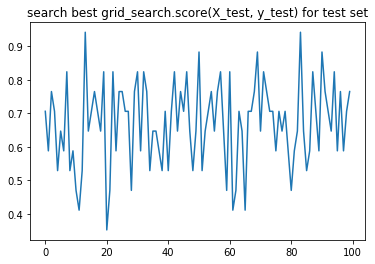

In [267]:
import matplotlib.pyplot as plt
plt.title('search best grid_search.score(X_test, y_test) for test set')
plt.plot(nrange, grid_score_test)

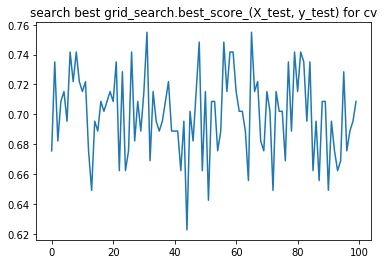

In [268]:
import matplotlib.pyplot as plt
plt.title('search best grid_search.best_score_(X_test, y_test) for cv')
plt.plot(nrange, grid_score_cv)

In [269]:
predictor = grid_search.best_estimator_
predictor

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [270]:
predictor.coef_

array([[-0.02786862, -0.06891568, -0.1186478 , -0.00563523, -0.05797508,
        -0.04716085, -0.04642773, -0.06950367, -0.06879915, -0.02950296,
        -0.03501566, -0.05072578, -0.03702379,  0.14817971, -0.03598125,
        -0.11564758, -0.10508084, -0.11253737],
       [-0.02130909, -0.0948153 , -0.05118555, -0.03479768,  0.01137726,
        -0.04770201, -0.04018834, -0.12559453, -0.06286199, -0.05732471,
        -0.04402229, -0.03411521, -0.00378341, -0.09437091,  0.081602  ,
        -0.00614461, -0.06885048, -0.11434362],
       [-0.05587498, -0.09192577, -0.07403953, -0.00419917, -0.06800008,
        -0.04685751, -0.02670078, -0.08448107, -0.03476001, -0.03729212,
        -0.04267834, -0.02111556, -0.09019341, -0.11141533, -0.10904986,
         0.06188222,  0.00748016, -0.07493663],
       [-0.02932723, -0.11909107, -0.04055993, -0.02519957, -0.07632592,
        -0.02048326, -0.0482454 , -0.06912321,  0.00030498, -0.04765634,
        -0.04258937, -0.06941055, -0.05482652, -0.112

In [271]:
predictor.intercept_

array([-0.22106733, -0.20210761, -0.22603944, -0.21417779])

In [272]:
coef_df = pd.DataFrame(predictor.coef_, index=['~3.3','3.3~8.2','8.2~19','19~'] , columns=X_train.columns)
coef_df

,Strain_1,Strain_2,Strain_3,Strain_4,Orien_1,Orien_2,Orien_3,Orien_4,Aspect_1.0,Aspect_2.0,Aspect_3.0,Aspect_4.0,Aspect_5.0,Size_1.0,Size_2.0,Size_3.0,Size_4.0,Size_5.0
~3.3,-0.027869,-0.068916,-0.118648,-0.005635,-0.057975,-0.047161,-0.046428,-0.069504,-0.068799,-0.029503,-0.035016,-0.050726,-0.037024,0.148180,-0.035981,-0.115648,-0.105081,-0.112537
3.3~8.2,-0.021309,-0.094815,-0.051186,-0.034798,0.011377,-0.047702,-0.040188,-0.125595,-0.062862,-0.057325,-0.044022,-0.034115,-0.003783,-0.094371,0.081602,-0.006145,-0.068850,-0.114344
8.2~19,-0.055875,-0.091926,-0.074040,-0.004199,-0.068000,-0.046858,-0.026701,-0.084481,-0.034760,-0.037292,-0.042678,-0.021116,-0.090193,-0.111415,-0.109050,0.061882,0.007480,-0.074937
19~,-0.029327,-0.119091,-0.040560,-0.025200,-0.076326,-0.020483,-0.048245,-0.069123,0.000305,-0.047656,-0.042589,-0.069411,-0.054827,-0.112002,-0.120229,-0.116274,0.005815,0.128512


In [273]:
coef_df.columns = [i.replace('_', '').replace('.0', '') for i in coef_df.columns]

In [274]:
coef_df.to_csv('coef_subtraction.csv')

In [442]:
temp_1 = coef_df.iloc[0, :]+predictor.intercept_[0]
temp_2 = coef_df.iloc[1, :]+predictor.intercept_[1]
temp_3 = coef_df.iloc[2, :]+predictor.intercept_[2]
temp_4 = coef_df.iloc[3, :]+predictor.intercept_[3]

In [433]:
a1 = np.dot(temp_1, X_test.loc[4,:])
a1

-1.1349296543577692

In [434]:
a2 = np.dot(temp_2, X_test.loc[4,:])
a2

-1.0771229549328138

In [435]:
a3 = np.dot(temp_3, X_test.loc[4,:])
a3

-1.0727529901307595

In [436]:
a4 = np.dot(temp_4, X_test.loc[4,:])
a4

-1.0381266429037639

In [437]:
np.exp(a1)/(np.exp(a1)+np.exp(a2)+np.exp(a3)+np.exp(a4))

0.2366693705860108

In [438]:
np.exp(a2)/(np.exp(a1)+np.exp(a2)+np.exp(a3)+np.exp(a4))

0.25075360553414644

In [439]:
np.exp(a3)/(np.exp(a1)+np.exp(a2)+np.exp(a3)+np.exp(a4))

0.2518517877254524

In [440]:
np.exp(a4)/(np.exp(a1)+np.exp(a2)+np.exp(a3)+np.exp(a4))

0.2607252361543904

In [371]:
test_for_pp = X_test.copy()
test_for_pp['predict'] = grid_search.predict(X_test)

In [405]:
test_for_pp

,Strain_1,Strain_2,Strain_3,Strain_4,Orien_1,Orien_2,Orien_3,Orien_4,Aspect_1.0,Aspect_2.0,Aspect_3.0,Aspect_4.0,Aspect_5.0,Size_1.0,Size_2.0,Size_3.0,Size_4.0,Size_5.0,predict
92,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1.0
165,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,4.0
103,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,3.0
144,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1.0
14,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,3.0
89,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4.0
24,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,3.0
159,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,3.0
4,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,3.0
134,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,2.0


In [450]:
coef_1 = np.exp(coef_df.iloc[0, :]+predictor.intercept_[0])
coef_2 = np.exp(coef_df.iloc[1, :]+predictor.intercept_[1])
coef_3 = np.exp(coef_df.iloc[2, :]+predictor.intercept_[2])
coef_4 = np.exp(coef_df.iloc[3, :]+predictor.intercept_[3])
softmax_1 = coef_1/(coef_1+coef_2+coef_3+coef_4)
softmax_2 = coef_2/(coef_1+coef_2+coef_3+coef_4)
softmax_3 = coef_3/(coef_1+coef_2+coef_3+coef_4)
softmax_4 = coef_4/(coef_1+coef_2+coef_3+coef_4)

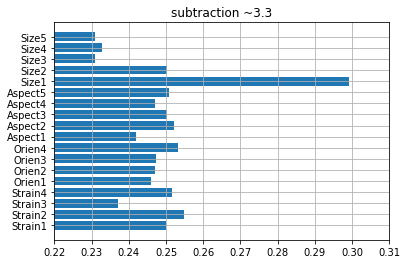

In [331]:
import matplotlib.pyplot as plt

plt.barh(softmax_1.index, softmax_1, align='center')
plt.grid()
plt.xlim(xmin=0.22, xmax=0.31)
plt.title('subtraction ~3.3')
plt.show()

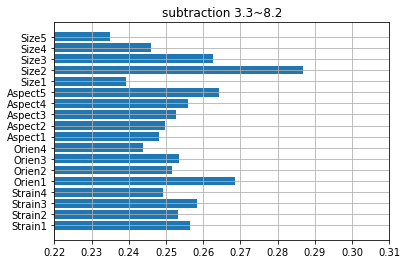

In [336]:
plt.barh(softmax_2.index, softmax_2, align='center')
plt.grid()
plt.xlim(xmin=0.22, xmax=0.31)
plt.title('subtraction 3.3~8.2')
plt.show()

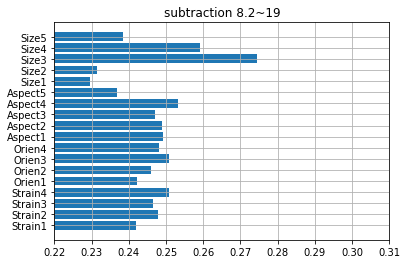

In [337]:
plt.barh(softmax_3.index, softmax_3, align='center')
plt.grid()
plt.xlim(xmin=0.22, xmax=0.31)
plt.title('subtraction 8.2~19')
plt.show()

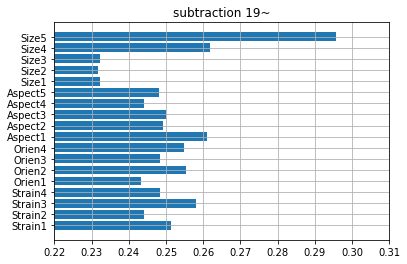

In [452]:
plt.barh(softmax_4.index, softmax_4, align='center')
plt.grid()
plt.xlim(xmin=0.22, xmax=0.31)
plt.title('subtraction 19~')
plt.show()

# 4次元入力　3クラス分類のロジスティック回帰モデル

In [280]:
W = np.array([[0.9385, 1.2791, 0.585],[3.0297, 3.124, 1.5294],
              [-1.3539, -0.9422, -1.0328],[-10.5264, 47.4803, 44.8393],[7.0762, 22.773, 26.0028]])

In [281]:
def soft():
    all = []
    x = [2,1,3,3]
    for i in (0, 1, 2):
        a = x[0]*W[0][i] + x[1]*W[1][i] + x[2]*W[2][i] + x[3]*W[3][i] + 1.0*W[4][i]
        all = all + [a]
    print(all,': all here')
    print(np.exp(all[0])/(np.exp(all[0])+np.exp(all[1])+np.exp(all[2])))
    print(np.exp(all[1])/(np.exp(all[0])+np.exp(all[1])+np.exp(all[2])))
    print(np.exp(all[2])/(np.exp(all[0])+np.exp(all[1])+np.exp(all[2])))

In [282]:
soft()

[-23.658, 168.0695, 160.1217] : all here
5.415658258253209e-84
0.999646685999444
0.0003533140005560378


# K近傍法

In [283]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 17)
knn.fit(X_train,y_train)
Y_pred = knn.predict(X_test)

print(metrics.accuracy_score(y_test,Y_pred))

0.8235294117647058


In [284]:
k_range = range(1, 90)
accuracy = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    Y_pred = knn.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, Y_pred))

Text(0,0.5,'Testing Accuracy')

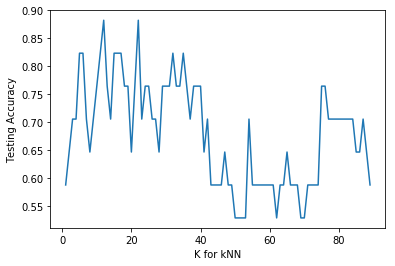

In [285]:
import matplotlib.pyplot as plt

plt.plot(k_range, accuracy)
plt.xlabel('K for kNN')
plt.ylabel('Testing Accuracy')